In [1]:
targetFolderHBK = r"G:\Semester Arbeit\Programming\Extracted_Features\HBK\HBK_14285Hz_highpass_all_features\features"
targetFolderMCC5 = r"G:\Semester Arbeit\Programming\Extracted_Features\MCC5\MCC5_12800Hz_highpass_all_features_motor_vibration_x\features"
targetFolderSIZA = r"G:\Semester Arbeit\Programming\Extracted_Features\SIZA\SIZA_highpass_all_features\features"
normalization_method = "z_score"

In [2]:
experiment_name = "Continual_Learning_Analysis_binary"
project_name="Continual_Learning_Analysis_binary",
run_name="Continual_Learning_Analysis_binary"
domain="freq"

domains_to_use = ['frequency']

In [3]:
binary_classification=True
plot_histograms_choice=False
include_augmentations=True

## Import Libraries

In [4]:
# 1. Standard Library Imports
import os
import glob
import pickle
from pathlib import Path
from collections import Counter
from typing import (
    Callable, Generator, Generic, List, Sequence, TypeVar, 
    Union, Tuple, Optional, Iterable, Dict
) # Added based on your use of Avalanche internals

# 2. Third-Party Library Imports

# Scientific/Data Handling
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# PyTorch
import torch
from torch import tensor
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data.dataset import TensorDataset, random_split

# PyCaret
from pycaret.classification import *

# Optuna
import optuna

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
)
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, 
    jaccard_score, log_loss, precision_score, recall_score, f1_score, 
    make_scorer
)

# TorchMetrics
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy

# Avalanche
from avalanche.benchmarks import task_incremental_benchmark
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.utils import AvalancheDataset, DataAttribute
from avalanche.evaluation.metrics import (
    forgetting_metrics, accuracy_metrics, loss_metrics, timing_metrics, 
    cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics, class_accuracy_metrics, topk_acc_metrics
)
from avalanche.logging import InteractiveLogger
from avalanche.models import SimpleMLP, SimpleCNN, MTSimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import DER # Consolidated DER here

# 3. Local Application/Project Imports
from data_loader import load_feature_data

## Helper Functions

In [5]:
def select_features_by_domain(domains: list, available_features: dict = None) -> list:
    """
    Selects a list of features based on the specified domains.

    Args:
        domains: A list of domain names (e.g., ['time', 'frequency']).
        available_features: A dictionary mapping domain names (keys) to 
                            lists of features (values). If None, uses a 
                            default dictionary.

    Returns:
        A flat list of all selected features.
    """
    # Define the complete feature set structure
    if available_features is None:
        available_features = {
            'time': ['rms', 'std', 'crest', 'energy', 'entropy'],
            'frequency': ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness'],
            # Assuming 'Time-Frequency' is referred to by a simpler domain name, 
            # or you can keep the full name
            'time-frequency': ['meanWavelet', 'varWavelet', 'entropyWavelet', 'entropySpectrogram']
        }

    selected_features = []
    
    # Iterate over the requested domains and extend the list
    for domain in domains:
        # Convert domain to lowercase for case-insensitive matching
        domain_key = domain.lower().replace('_', '-').strip()
        
        if domain_key in available_features:
            selected_features.extend(available_features[domain_key])
        else:
            print(f"Warning: Domain '{domain}' not recognized in available features.") # Optional warning

    # Return only unique features in case of overlap (though unlikely here)
    return list(set(selected_features))

In [6]:
features_to_include = select_features_by_domain(domains=domains_to_use)

In [7]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

## Import Datasets

In [8]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 966 files into a DataFrame with shape (1140403, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['spectral_entropy', 'spectral_skewness', 'medianFreq', 'meanFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (1140403, 5)


In [9]:
df_SIZA = load_feature_data(
    features_path=targetFolderSIZA,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 1878 files into a DataFrame with shape (953091, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['spectral_entropy', 'spectral_skewness', 'medianFreq', 'meanFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (953091, 5)


In [10]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 216 files into a DataFrame with shape (307368, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['spectral_entropy', 'spectral_skewness', 'medianFreq', 'meanFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (307368, 5)


In [11]:
normalized_HBK = normalizeDataframe(df_HBK, normalization_method)
normalized_SIZA = normalizeDataframe(df_SIZA, normalization_method)
normalized_MCC5 = normalizeDataframe(df_MCC5, normalization_method)

In [12]:
label_encoder = LabelEncoder()

# 1. Combine all labels into a single pandas Series
all_labels = pd.concat([
    normalized_HBK['Label'],
    normalized_SIZA['Label'],
    normalized_MCC5['Label']
], ignore_index=True)

# 2. FIX: Convert all combined labels to a string type to ensure uniformity
all_labels_str = all_labels.astype(str)

# 3. Now, fit the encoder on the purely string data
label_encoder.fit(all_labels_str)

# 4. Transform the labels in each original DataFrame (also converting them to string first)
normalized_HBK['Label'] = label_encoder.transform(normalized_HBK['Label'].astype(str))
normalized_SIZA['Label'] = label_encoder.transform(normalized_SIZA['Label'].astype(str))
normalized_MCC5['Label'] = label_encoder.transform(normalized_MCC5['Label'].astype(str))

print("Labels successfully encoded.")

Labels successfully encoded.


### Create Tensor Datasets

In [13]:
# Assuming X_hbk, y_hbk, X_siza, y_siza, X_mcc5, y_mcc5 are numpy arrays
X_hbk, y_hbk = normalized_HBK.drop('Label', axis=1).values, normalized_HBK['Label'].values
X_siza, y_siza = normalized_SIZA.drop('Label', axis=1).values, normalized_SIZA['Label'].values
X_mcc5, y_mcc5 = normalized_MCC5.drop('Label', axis=1).values, normalized_MCC5['Label'].values

# Convert numpy arrays to PyTorch Tensors
X_hbk_tensor, y_hbk_tensor = torch.tensor(X_hbk, dtype=torch.float32), torch.tensor(y_hbk, dtype=torch.long)
X_siza_tensor, y_siza_tensor = torch.tensor(X_siza, dtype=torch.float32), torch.tensor(y_siza, dtype=torch.long)
X_mcc5_tensor, y_mcc5_tensor = torch.tensor(X_mcc5, dtype=torch.float32), torch.tensor(y_mcc5, dtype=torch.long)

hbk_tensor_dataset = TensorDataset(X_hbk_tensor, y_hbk_tensor)
siza_tensor_dataset = TensorDataset(X_siza_tensor, y_siza_tensor)
mcc5_tensor_dataset = TensorDataset(X_mcc5_tensor, y_mcc5_tensor)

# --- Splitting Datasets ---
def split_dataset(full_dataset, ratio=0.8):
    train_size = int(ratio * len(full_dataset))
    test_size = len(full_dataset) - train_size
    return random_split(full_dataset, [train_size, test_size])

hbk_train_subset, hbk_test_subset = split_dataset(hbk_tensor_dataset)
siza_train_subset, siza_test_subset = split_dataset(siza_tensor_dataset)
mcc5_train_subset, mcc5_test_subset = split_dataset(mcc5_tensor_dataset)

# --- Function to extract targets and task labels for a subset ---
def get_attributes_for_subset(subset, full_targets_tensor, task_id):
    # Extract the targets (y) and create task labels (t) for the Subset indices
    targets_list = [full_targets_tensor[i].item() for i in subset.indices]
    task_labels_tensor = torch.full((len(subset),), task_id, dtype=torch.long)
    
    return [
        DataAttribute(targets_list, 'targets'),
        DataAttribute(task_labels_tensor, 'targets_task_labels', use_in_getitem=True)
    ]

In [14]:
input_features = X_hbk_tensor.shape[1] 
# Assuming num_classes is 5 (from your previous code)
num_classes = 2 

# --- Create Avalanche Datasets ---

# Task 0 (HBK)
avl_train_hbk = AvalancheDataset(hbk_train_subset, data_attributes=get_attributes_for_subset(hbk_train_subset, y_hbk_tensor, 0))
avl_test_hbk = AvalancheDataset(hbk_test_subset, data_attributes=get_attributes_for_subset(hbk_test_subset, y_hbk_tensor, 0))

# Task 1 (SIZA)
avl_train_siza = AvalancheDataset(siza_train_subset, data_attributes=get_attributes_for_subset(siza_train_subset, y_siza_tensor, 1))
avl_test_siza = AvalancheDataset(siza_test_subset, data_attributes=get_attributes_for_subset(siza_test_subset, y_siza_tensor, 1))

# Task 2 (MCC5)
avl_train_mcc5 = AvalancheDataset(mcc5_train_subset, data_attributes=get_attributes_for_subset(mcc5_train_subset, y_mcc5_tensor, 2))
avl_test_mcc5 = AvalancheDataset(mcc5_test_subset, data_attributes=get_attributes_for_subset(mcc5_test_subset, y_mcc5_tensor, 2))

# --- Create Benchmark ---
streams_dict = {
    'train': [avl_train_hbk, avl_train_siza, avl_train_mcc5],
    'test': [avl_test_hbk, avl_test_siza, avl_test_mcc5]
}

bm = benchmark_from_datasets(**streams_dict)
#bm = task_incremental_benchmark(bm)

In [15]:
# 4. Training Loop Setup
model = SimpleMLP(input_size=input_features, num_classes=num_classes)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    #timing_metrics(epoch=True, epoch_running=True),
    class_accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True), 
    forgetting_metrics(experience=True, stream=True),
    #cpu_usage_metrics(experience=True),
    confusion_matrix_metrics(num_classes=num_classes, save_image=True, stream=True),
    loggers=[InteractiveLogger()],
    
)


cl_strategy = DER(
    model, optimizer, criterion,
    train_mb_size=528,
    train_epochs=10, 
    eval_mb_size=528,
    evaluator=eval_plugin
)


Starting 3-Task Experiment...
Start training on Task 0 (Data: AvalancheDataset)
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████| 1728/1728 [00:55<00:00, 31.15it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream = 0.3581
	Loss_MB/train_phase/train_stream = 0.3218
	Top1_Acc_Epoch/train_phase/train_stream = 0.8296
	Top1_Acc_MB/train_phase/train_stream = 0.8584
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9193
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.5705
	Top1_ClassAcc_MB/train_phase/train_stream/Task000/0 = 0.9341
	Top1_ClassAcc_MB/train_phase/train_stream/Task000/1 = 0.6667
100%|██████████████████████████████████████████████████████████████████████████████| 1728/1728 [00:55<00:00, 31.41it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream = 0.3014
	Loss_MB/train_phase/train_stream = 0.3092
	Top1_Acc_Epoch/train_phase/train_stream = 0.8687
	Top1_Acc_MB/train_phase/train_stre

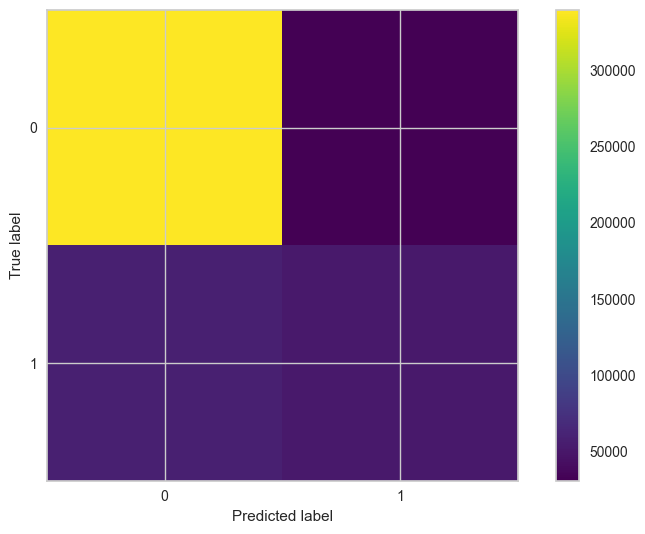

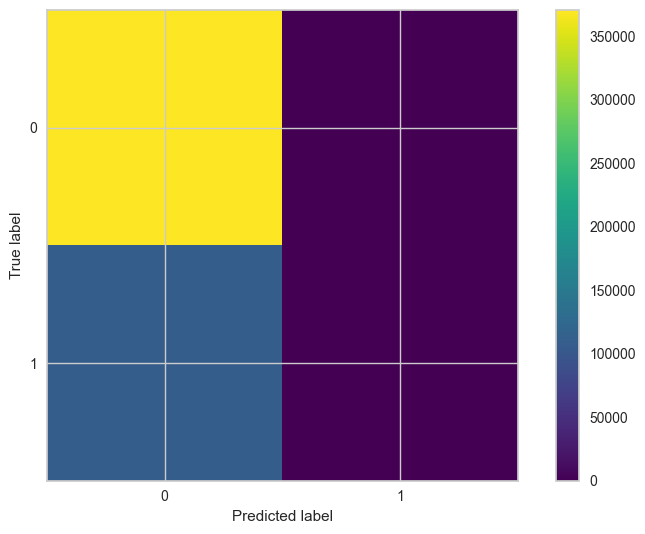

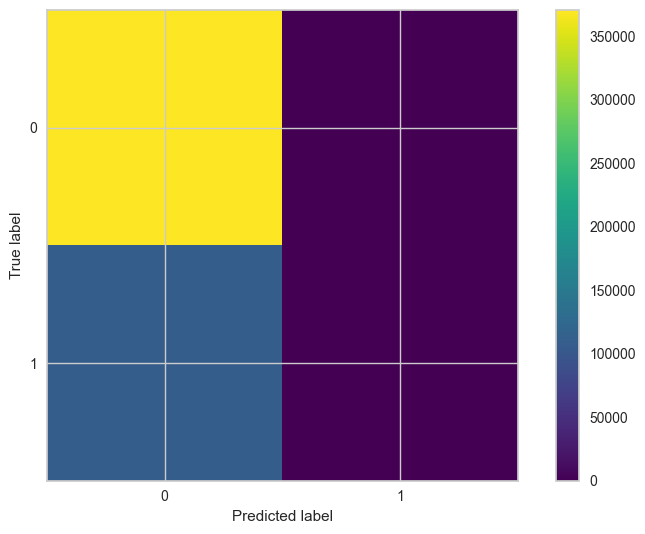

In [16]:
# TRAINING LOOP
print('Starting 3-Task Experiment...')
results = []
for experience in bm.train_stream:
    # Manually attach the benchmark object to the experience
    experience.benchmark = bm 
    
    print(f'Start training on Task {experience.current_experience} (Data: {experience.dataset.__class__.__name__})')
    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    
    # 🌟 FIX: Manually attach the benchmark to the experiences in the test stream too
    # This is needed because cl_strategy.eval will iterate over bm.test_stream
    for test_exp in bm.test_stream:
        test_exp.benchmark = bm
        
    results.append(cl_strategy.eval(bm.test_stream))

print('Experiment finished.')